In [1]:
%cd ../src

/home/ubuntu/SPVD_Lightning/src


In [2]:
import torch
torch.set_float32_matmul_precision('medium')

In [3]:
from datasets.shapenet.shapenet_loader import get_dataloaders

categories = ['airplane', 'chair']
path = "../data/ShapeNet"
tr, te, val = get_dataloaders(path, categories=categories, load_renders=True)

Loading (val) renders for chair (03001627): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [00:17<00:00, 37.41it/s]


In [4]:
from my_models.spvd import SPVUnet

model_params = {
    "features": (32, 32, 64, 128, 256),
    "attn_heads_list": (None, None, None, 8),
    "cross_attn_heads_list": (None, None, 8, 8),
    "cross_attn_cond_dim": 768,
}

model = SPVUnet(**model_params)

In [5]:
from my_models.lightning_base import DiffusionBase
from my_schedulers.ddpm_scheduler import DDPMSparseScheduler
ddpm_sched = DDPMSparseScheduler(beta_min=0.0001, beta_max=0.02, steps=1024)

model = DiffusionBase(model)
model.set_noise_scheduler(ddpm_sched)

In [8]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint

# Save every 50 epochs, with epoch number in filename
checkpoint = ModelCheckpoint(
    dirpath="../checkpoints/ShapeNet",
    filename="chair-airplane-{epoch:03d}",  # e.g., model-epoch=050.ckpt
    every_n_epochs=50,            # Save interval
    save_top_k=-1,                # Keep all checkpoints (-1 = no limit)
)

epochs = 500
trainer = L.Trainer(
    log_every_n_steps=5,
    max_epochs=epochs,
    # callbacks=[checkpoint],
    gradient_clip_val=10.0,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model=model, train_dataloaders=tr, val_dataloaders=val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | SPVUnet | 25.4 M | train
------------------------------------------
25.4 M    Trainable params
0         Non-trainable params
25.4 M    Total params
101.443   Total estimated model params size (MB)
275       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
import os
os.makedirs("../checkpoints/ShapeNet/", exist_ok=True)
checkpoint = {
    "state_dict": model.state_dict(),
    "model_params": model_params,
}
torch.save(checkpoint, "../checkpoints/ShapeNet/chair-airplane-500.ckpt")

In [10]:
import numpy as np
samples = 16
references = [tr.dataset[idx] for idx in np.random.choice(list(range(len(tr.dataset))), size=(16,))]
reference_images = torch.stack([r["render-features"] for r in references]).to("cuda")

In [11]:
from my_schedulers.ddpm_scheduler import DDPMSparseScheduler
ddpm_sched = DDPMSparseScheduler(beta_min=0.0001, beta_max=0.02, steps=1024)

In [12]:
samples = 16
model = model.cuda().eval()
preds = ddpm_sched.sample(model, samples, 4096, reference=reference_images, stochastic=True)


Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:06<00:00, 15.42it/s]


In [13]:
from utils.visualization import display_pointclouds_grid

In [14]:
display_pointclouds_grid(preds.cpu().numpy(), offset=8, point_size=0.3)

Output()

In [15]:
real = np.array([r["pc"] for r in references])
display_pointclouds_grid(real, offset=8, point_size=0.3)

Output()

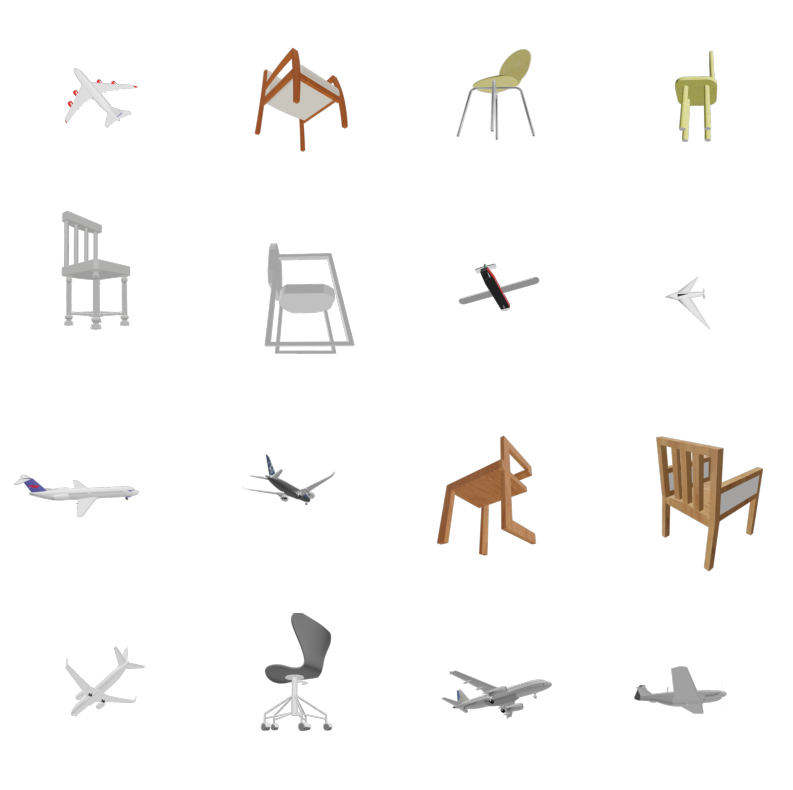

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        ax = axs[i][j]
        ax.axis('off')
        idx = i * 4 + j
        view = references[idx]["selected-view"]
        file = references[idx]["filename"]

        img = mpimg.imread(f"../data/ShapeNet/renders/{file}/00{view}.png")
        ax.imshow(img)